# Ray tracing of refraction case using WAVEWATCH III outputs

This notebook uses output data from NOAA's [WAVEWATCH III](https://polar.ncep.noaa.gov/waves/wavewatch/) model. 

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

import sys
sys.path.append('./python')
import mantaray

In [2]:
g = 9.8
def period2wavenumber(T):
    k = (2*np.pi)**2/g/T**2
    return k

def group_velocity(k):
    cg = 0.5*(g/k)**.5
    return cg

## Initialize wave parameters

In [4]:
# Period of incident waves in seconds
T0 = 11

# Direction of incident waves in radians (trig convention, going to)
theta_deg = 306.4
theta0 = np.deg2rad(theta_deg)

# Convert period to wavenumber magnitude
k0 = period2wavenumber(T0)

# Calculate wavenumber components
kx0 = k0*np.cos(theta0)
ky0 = k0*np.sin(theta0)

# Number of rays
n_rays = 100

# Initialize wavenumber for all rays
Kx0 = kx0*np.ones(n_rays)
Ky0 = ky0*np.ones(n_rays)

# Current and bathymetry file path
ww_bathy = 'forcing/wavewatch_bathy.nc'
ww_currs = 'forcing/wavewatch_currents.nc'

ds = xr.open_dataset(ww_currs)

x = ds.x.values
y = ds.y.values

# Creates initial x position for all rays
x0 = np.linspace(0, 400000, num=n_rays)  
y0 = np.full_like(x0, 420000)

# Estimates CFL
# Computes grid smallest spacing
dd = np.min([np.diff(x).mean(), np.diff(y).mean()])

# Computes group velocity
cg = group_velocity(k0)

# Computes CFL
cfl = dd/cg

duration = round(x.max()/cg)
step_size = cfl

## Initialize ray tracing

In [5]:
bundle = mantaray.ray_tracing(x0, y0, Kx0, Ky0, duration, step_size, ww_bathy, ww_currs)

## Plot WAVEWATCH III currents and $H_s$

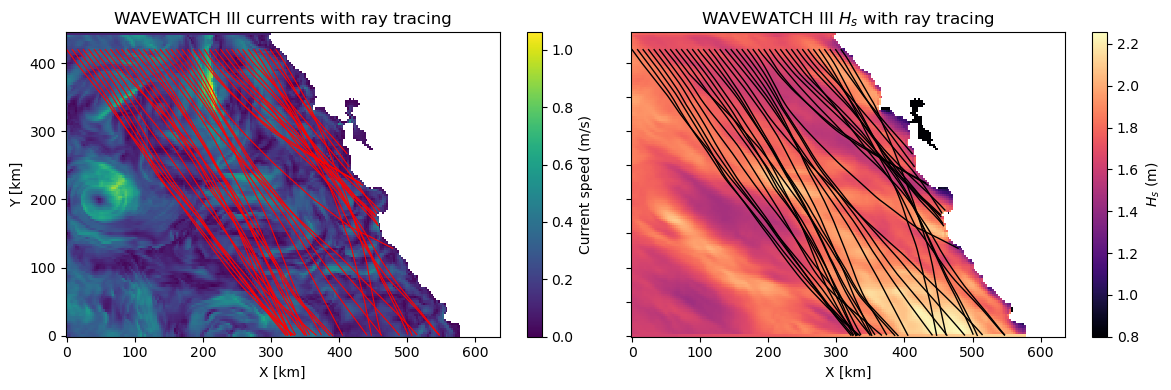

In [31]:
# define x, y, and current speed for plotting
X = ds.x
Y = ds.y
U = (ds.u**2 + ds.v**2)**.5

# initialize subplot
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# plot first subplot
cs1 = axes[0].pcolormesh(X, Y, U)
for i in range(bundle.ray.size)[::2]:
    ray = bundle.isel(ray=i)
    axes[0].plot(ray.x, ray.y, color='red', lw=0.8)
fig.colorbar(cs1, ax=axes[0], label='Current speed (m/s)')
axes[0].set_title('WAVEWATCH III currents with ray tracing')
# set xticks to kilometers
axes[0].set_xlabel('X [km]')
axes[0].set_xticks(np.arange(0,700_000, 100_000))
axes[0].set_xticklabels(np.arange(0,700, 100))
# set yticks to kilometers
axes[0].set_ylabel('Y [km]')
axes[0].set_yticks(np.arange(0, 500_000, 100_000))
axes[0].set_yticklabels(np.arange(0, 500, 100))

# plot second subplot
cs2 = axes[1].pcolormesh(X, Y, hs, cmap='magma', vmin=0.8, vmax=np.max(hs))
for i in range(bundle.ray.size)[::2]:
    ray = bundle.isel(ray=i)
    axes[1].plot(ray.x, ray.y, color='black', lw=1)
fig.colorbar(cs2, ax=axes[1], label='$H_s$ (m)')
axes[1].set_title(f'WAVEWATCH III $H_s$ with ray tracing')
# set xticks to kilometers
axes[1].set_xlabel('X [km]')
axes[1].set_xticks(np.arange(0,700_000, 100_000))
axes[1].set_xticklabels(np.arange(0,700, 100))
axes[1].tick_params(labelleft=False)

plt.tight_layout()
plt.show()